# Validation of method

### Table of contents

1. [**Schematic of models**](#schem)
2. [**Synthetic**](#syn)
3. [**Biophysical**](#bio)
4. [**Place cells regression**](#place)
5. [**Place cells comodulation**](#corr)

In [167]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr

import optax
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

import pickle


import sys

sys.path.append("../../../GaussNeuro")
import gaussneuro as lib

sys.path.append("../../scripts/fit")

import template



import matplotlib.pyplot as plt
plt.style.use(['paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)

double_arrays = False

if double_arrays:
    jax.config.update("jax_enable_x64", True)
    array_type = "float64"
else:
    array_type = "float32"

seed = 123
prng_state = jr.PRNGKey(seed)
rng = np.random.default_rng(seed)

# Validation of method

### Table of contents

1. [**Heteroscedastic GP**](#hetero)
3. [**Renewal process GP**](#renewal)
4. [**GP-GLM**](#gpglm)

In [169]:
%load_ext autoreload
%autoreload 2

from functools import partial
import numpy as np
import scipy
from scipy.ndimage import convolve1d

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

from tqdm.autonotebook import tqdm

import sys
sys.path.append("../../../GaussNeuro/")
import gaussneuro as gn


import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
jax.config.update("jax_enable_x64", True)
array_type = 'float64'

# seed everything
seed = 1234
prng_state = jax.random.PRNGKey(seed)
rng = np.random.default_rng(seed)

In [171]:
import plot_baselines

jitter = 1e-6
filters_dict = plot_baselines.spike_history_filters(rng, prng_state, jitter, array_type)

In [172]:
a, c = 6., 30.
phi_lower, phi_upper = a * np.log(c) - np.pi, (a * np.log(500 + c) + np.pi) * 0.87
print(phi_lower, phi_upper)

17.26559163638314 35.47760358279412


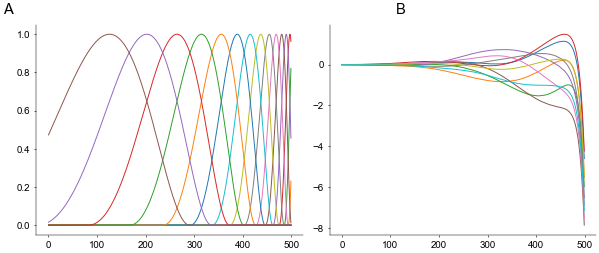

In [173]:
fig = plt.figure(figsize=(8, 3))
fig.text(-0.05, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.65, 1.05, 'B', fontsize=15, ha='center')



widths = [1, 1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1., wspace=0.1)

ax = fig.add_subplot(spec[0, 0])

filter_t = filters_dict["glm_filter"]
t = np.arange(filter_t.shape[0])
ax.plot(t, filter_t[:, :, 0])


ax = fig.add_subplot(spec[0, 1])

filter_t = filters_dict["gp_filter"]
t = np.arange(filter_t.shape[1])

tr = 2
ax.plot(t, filter_t[:, :, 1, 0].T)



plt.show()

### Schematic of model

In [4]:
# animal position
x_dims = 2
num_samps = 1
prng_state = jax.random.PRNGKey(123)

jitter = 1e-6


var_x = 1.0*np.ones((x_dims))  # GP variance
len_x = 1.0*np.ones((x_dims, 1))  # GP lengthscale

kernx = lib.GP.kernels.Matern52(x_dims, variance=var_x, lengthscale=len_x)


# site_init
Tsteps = 4
site_locs = np.linspace(0.0, 1., Tsteps)  # s
site_obs = 0. * np.ones([Tsteps, x_dims, 1]) + 0*np.random.randn(Tsteps, x_dims, 1)
site_Lcov = 0.01 * np.eye(x_dims)[None, ...].repeat(Tsteps, axis=0)

state_space = lib.GP.markovian.GaussianLTI(
    kernx, site_locs, site_obs, site_Lcov, diagonal_site=True, fixed_grid_locs=False)


evalsteps = 1000
t_eval = jnp.linspace(0.0, 10.0, evalsteps)
pos_prior_samples = state_space.sample_prior(
    prng_state, num_samps, t_eval, jitter)


<a id='models_IPP'></a>
### Renewal processes

In [50]:
def get_renewal(renewal_type, neurons, dt):
    if renewal_type == 'gamma':
        alpha = np.linspace(0.5, 3.5, neurons)
        renewal = lib.likelihoods.renewal.Gamma(
            neurons,
            dt,
            alpha,
        )

    elif renewal_type == 'lognorm':
        sigma = np.linspace(0.5, 1.5, neurons)
        renewal = lib.likelihoods.renewal.LogNormal(
            neurons,
            dt,
            sigma,
        )

    elif renewal_type == 'invgauss':
        mu = np.linspace(0.5, 1.5, neurons)
        renewal = lib.likelihoods.renewal.InverseGaussian(
            neurons,
            dt,
            mu,
        )
        
    elif renewal_type == 'exponential':
        renewal = lib.likelihoods.renewal.Exponential(
            neurons,
            dt,
        )
    
    return renewal

In [51]:
obs_dims = 3
dt = 1.

rm = get_renewal('gamma', obs_dims, dt)

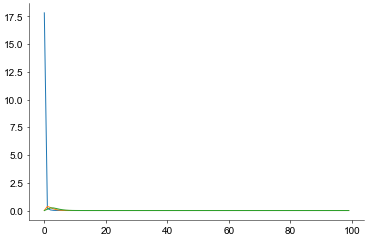

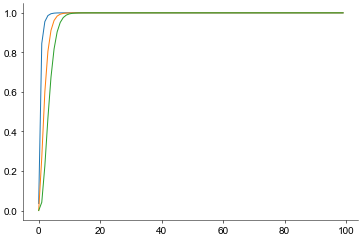

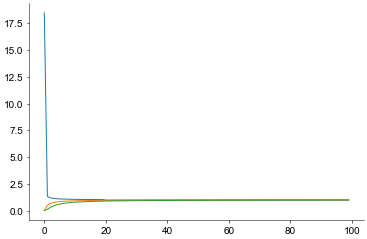

In [52]:
ISI = jnp.linspace(0.001, 100., 100)[:, None]

ll = jax.vmap(rm.log_density)(ISI)
plt.plot(np.exp(ll)[:, :])
plt.show()

cd = jax.vmap(rm.cum_density)(ISI)
plt.plot(cd[:, :])
plt.show()

lh = jax.vmap(rm.log_hazard)(ISI)
plt.plot(jnp.exp(lh[:, :]))
plt.show()

In [110]:
evalsteps = 500
num_samps = 10

cisi_t_eval = jnp.linspace(0.0, 5.0, evalsteps)
isi_cond = None#jnp.ones((f_dims, ISI_orders-1))
x_cond = jnp.ones((x_dims-1,))

# bnpp
wrap_tau = 1.0*np.ones((f_dims,))
refract_tau = 1e-1*np.ones((f_dims,))
refract_neg= -12.
mean_bias = 0.*np.ones((f_dims,))
dt = 1e-3  # s

bnpp = lib.inference.svgp.NonparametricPointProcess(
    svgp, wrap_tau, refract_tau, refract_neg, mean_bias, dt)

ISI_density = bnpp.sample_conditional_ISI(
    prng_state,
    num_samps,
    cisi_t_eval,
    isi_cond, 
    x_cond,
    int_eval_pts=1000,
    num_quad_pts=300,
    prior=True,
    jitter=1e-6, 
)


## Nonparametric non-renewal process

In [190]:
x_dims = 3
num_samps = 5
prng_state = jax.random.PRNGKey(123)

jitter = 1e-6


### state space GP ###
var_x = 1.0*np.ones((x_dims))  # GP variance
len_x = 0.3*np.ones((x_dims, 1))  # GP lengthscale

kernx = lib.GP.kernels.Matern52(x_dims, variance=var_x, lengthscale=len_x)


num_samps = 20
Tsteps = 1000

site_locs = np.linspace(0., 1., Tsteps)[None, :].repeat(x_dims, axis=0)  # s
site_obs = 0. * np.ones([x_dims, Tsteps, 1]) + 0*np.random.randn(x_dims, Tsteps, 1)
site_Lcov = 1. * np.ones([x_dims, Tsteps, 1]) + 0*np.random.randn(x_dims, Tsteps, 1)


# model
state_space = lib.GP.markovian.IndependentLTI(
    kernx, site_locs, site_obs, site_Lcov, fixed_grid_locs=True)


# evaluate
evalsteps = 2000
t_eval = jnp.linspace(0.0, 1.0, evalsteps)

prior_samples = state_space.sample_prior(
    prng_state, num_samps, t_eval, jitter)


post_mean, post_cov, _ = state_space.evaluate_posterior(
    t_eval, mean_only=False, compute_KL=False, jitter=1e-6)
post_mean = post_mean[..., 0]

post_samples, _ = state_space.sample_posterior(
    prng_state, num_samps, t_eval, jitter, False)  # (tr, time, N, 1)


In [122]:
evalsteps = 500
num_samps = 20

cisi_t_eval = jnp.linspace(0.0, 3.0, evalsteps)
isi_cond = None
x_cond = None

# non
wrap_tau = 1.0*np.ones((x_dims,))
refract_tau = 1e0*np.ones((x_dims,))
refract_neg= -0.
mean_bias = 0.*np.ones((x_dims,))
dt = 1e-3  # ms

bnpp = lib.inference.gp.NonparametricPointProcess(state_space, wrap_tau, refract_tau, refract_neg, mean_bias, dt)

nonrefr_renewal_density = bnpp.sample_conditional_ISI(
    prng_state,
    num_samps,
    cisi_t_eval,
    isi_cond, 
    x_cond,
    int_eval_pts=1000,
    num_quad_pts=100,
    prior=True,
)


# refractory
wrap_tau = 1.0*np.ones((x_dims,))
refract_tau = 1e0*np.ones((x_dims,))
refract_neg= -12.
mean_bias = 0.*np.ones((x_dims,))
dt = 1e-3  # ms

bnpp = lib.inference.gp.NonparametricPointProcess(state_space, wrap_tau, refract_tau, refract_neg, mean_bias, dt)

refr_renewal_density = bnpp.sample_conditional_ISI(
    prng_state,
    num_samps,
    cisi_t_eval,
    isi_cond, 
    x_cond,
    int_eval_pts=1000,
    num_quad_pts=100,
    prior=False,
)

[autoreload of lib.inference.svgp failed: Traceback (most recent call last):
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/scratches/ramanujan/dl543/py3_9env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class

AttributeError: module 'lib.inference' has no attribute 'gp'

In [ ]:
plt.plot(log_rho_t_mean[f_dim, :])

In [9]:
x_eval = None
time_eval = None
ini_spikes = None

ini_t_since = jnp.zeros((num_samps, x_dims))
past_ISIs = None

timesteps = 1000

y_samples, log_rho_ts, x_samples = bnpp.sample_prior(
    prng_state, num_samps, timesteps, x_eval, time_eval, ini_spikes, ini_t_since, past_ISIs, jitter)

TypeError: sample_prior() takes 9 positional arguments but 10 were given

In [253]:
evalsteps = 1000
evals = np.arange(evalsteps)

t_eval = np.zeros(evalsteps)
y = (np.random.randn(evalsteps) > 2.)

ISIs = lib.utils.neural.get_lagged_ISIs(y[:, None], 4, dt)

In [263]:
t_eval = ISIs[:, 0, 0]*100#jnp.linspace(0.0, 100.0, evalsteps)
isi_eval = None
x_eval = None

y = None

log_rho_t_mean, log_rho_t_cov = bnpp.evaluate_log_conditional_intensity(
    prng_state, t_eval, isi_eval, x_eval, jitter
)

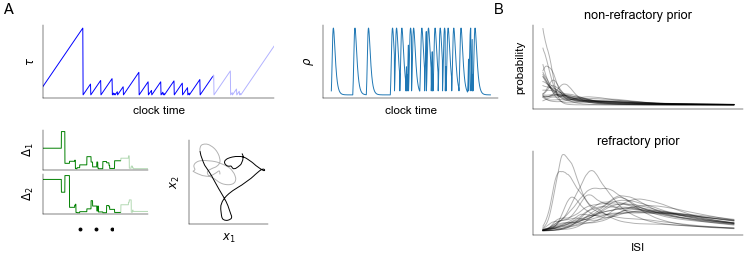

In [271]:
fig = plt.figure(figsize=(10, 3))
fig.text(-0.05, 1.05, 'A', fontsize=15, ha='center')
fig.text(0.65, 1.05, 'B', fontsize=15, ha='center')



widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.65, 
                        left=0.0, right=0.33, wspace=0.1)

ax = fig.add_subplot(spec[0, 0])
T = 800
ax.plot(evals[:T], ISIs[:T, 0, 0], c='b')
ax.plot(evals[T:], ISIs[T:, 0, 0], c='b', alpha=0.3)
ax.set_xlim([250, evalsteps])
ax.set_ylabel(r'$\tau$')
ax.set_yticks([])
ax.set_xlabel('clock time')
ax.set_xticks([])


widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.5, bottom=0.1, 
                        left=0.0, right=0.15, hspace=0.1)

T = 800
for k in range(2):
    ax = fig.add_subplot(spec[k, 0])
    ax.plot(evals[:T], ISIs[:T, 0, k+1], c='g')
    ax.plot(evals[T:], ISIs[T:, 0, k+1], c='g', alpha=0.3)
    ax.set_xlim([250, evalsteps])
    ax.set_xticks([])
    ax.set_ylim(0)
    ax.set_yticks([])
    ax.set_ylabel('$\Delta_{}$'.format(k+1))


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.45, bottom=0.05, 
                        left=0.18, right=0.35, wspace=0.0)

ax = fig.add_subplot(spec[0, 0])
T = 500
ax.plot(pos_prior_samples[0, :T, 0], pos_prior_samples[0, :T, 1], c='k')
ax.plot(pos_prior_samples[0, T:, 0], pos_prior_samples[0, T:, 1], alpha=0.3, c='k')
ax.set_aspect('equal')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xticks([])
ax.set_yticks([])


widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=0.05, bottom=0.0, 
                        left=0.05, right=0.1, wspace=0.0)
ax = fig.add_subplot(spec[0, 0])
ax.scatter(np.arange(3), -10*np.ones(3), c='k')
ax.axis('off')


### intensity ###
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.65, 
                        left=0.4, right=0.65, wspace=0.1)

ax = fig.add_subplot(spec[0, 0])
ax.plot(np.exp(log_rho_t_mean[0, :]))
ax.set_ylabel(r'$\rho$')
ax.set_xlabel(r'clock time')
ax.set_yticks([])
ax.set_xticks([])



### ISIs ###
widths = [1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.7, right=1.0, hspace=0.5)


n = 0
f_dim = 0

ax = fig.add_subplot(spec[0, 0])
ax.plot(cisi_t_eval, nonrefr_renewal_density[:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('probability')
ax.set_title('non-refractory prior', fontsize=13)

ax = fig.add_subplot(spec[1, 0])
ax.plot(cisi_t_eval, refr_renewal_density[:, f_dim, :].T, c='k', alpha=0.3)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('ISI')
ax.set_title('refractory prior', fontsize=13)



#plt.savefig('output/schematic.pdf')
plt.show()

NameError: name 'an_pos' is not defined

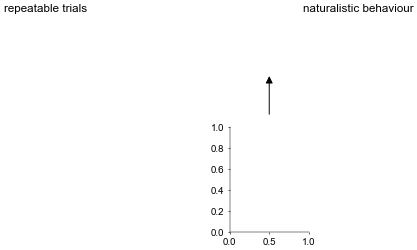

In [85]:
fig = plt.figure(figsize=(8, 3))

fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')


    
### behaviour ###


# position
tps = [300, 1000, 1700]
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, hspace=0.0, 
                        height_ratios=heights, top=0.5, bottom=0.0, 
                        left=0.55, right=1., wspace=0.1)

for k in range(3):
    ax = fig.add_subplot(spec[0, k])
    
    ax.annotate("", xy=(0.5, 1.5), xytext=(0.5, 1.1), rotation=np.pi/2., xycoords='axes fraction', 
                arrowprops=dict(arrowstyle="-|>, head_width=.3, head_length=.6", color='k'), 
                annotation_clip=False)
    
    tp = tps[k]

    x = an_pos[0, 0, tp]
    y = an_pos[0, 1, tp]
    dx = (an_pos[0, 0, tp+1]-an_pos[0, 0, tp])*100
    dy = (an_pos[0, 1, tp+1]-an_pos[0, 1, tp])*100

    ax.scatter(x, y, marker='o', facecolor='k', s=40)
    #ax.arrow(x, y, dx, dy)
    ax.plot(an_pos[0, 0, :tp], an_pos[0, 1, :tp], c='k')
    ax.plot(an_pos[0, 0, tp:], an_pos[0, 1, tp:], c='lightgray')
    ylims = ax.get_ylim()
    ax.set_ylim(-2.4, 2.4)
    ax.set_xlim(-2.4, 2.4)
    ax.set_aspect(1.)
    utils.plot.decorate_ax(ax)
            
            
plt.savefig('output/comparison.pdf')
plt.show()

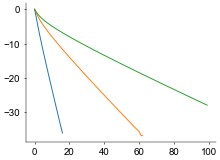

In [174]:
from tensorflow_probability.substrates import jax as tfp

igd = tfp.distributions.InverseGaussian(jnp.linspace(0.5, 1.5, 3), jnp.ones(3))

t = jnp.linspace(0.001, 100., 100)[:, None]
lh = igd.log_survival_function(t)

plt.plot((lh[:, :]))
plt.show()